# Lab3 Tutorial - Web scraping and Data Preprocessing

# Web scraping


In [3]:
!pip install pyppeteer nest_asyncio

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached pyppeteer-1.0.2-py3-none-any.whl (83 kB)
  Using cached importlib_metadata-4.10.1-py3-none-any.whl (17 kB)
     |████████████████████████████████| 138 kB 412 kB/s            
  Using cached pyee-8.2.2-py2.py3-none-any.whl (12 kB)
  Using cached certifi-2021.10.8-py2.py3-none-any.whl (149 kB)
  Using cached tqdm-4.62.3-py2.py3-none-any.whl (76 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
     |████████████████████████████████| 96 kB 632 kB/s            
  Using cached zipp-3.7.0-py3-none-any.whl (5.3 kB)
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discu

In [1]:
import asyncio
import nest_asyncio
from pyppeteer import launch

nest_asyncio.apply()

## Visiting an URL

In [5]:
async def main():
  browser = await launch({'headless': False})
  page = await browser.newPage() # open a new browser window
  await page.goto('https://www.hktvmall.com/hktv/en/main/search_a?keyword=Milk', { 'waitUntil':'networkidle0' }) # goto the url
  await page.screenshot({'path': 'example.png'}) # save screenshot as example.png
  await browser.close() # close browser window

In [6]:
asyncio.get_event_loop().run_until_complete(main())

[INFO] Starting Chromium download.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 86.8M/86.8M [03:18<00:00, 437kb/s]
[INFO] Beginning extraction
[INFO] Chromium extracted to: /Users/kenny/Library/Application Support/pyppeteer/local-chromium/588429


Showing `example.png` with `matplotlib`.

Fontconfig warning: ignoring UTF-8: not a valid region tag


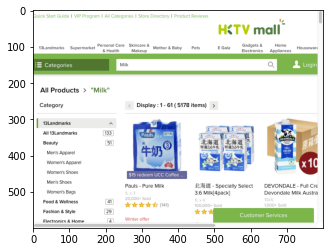

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('example.png')
plt.imshow(img)

## Selecting single element content in a page

Finding HTML element with CSS Selector and Javascript by `page.Jeval` (shortland of `page.querySelectorEvaluate`).

![](https://url2img-web.herokuapp.com/aHR0cHM6Ly9weXBwZXRlZXIuZ2l0aHViLmlvL3B5cHBldGVlci9yZWZlcmVuY2UuaHRtbCNweXBwZXRlZXIuZWxlbWVudF9oYW5kbGUuRWxlbWVudEhhbmRsZS5xdWVyeVNlbGVjdG9yRXZhbA==)

The second arguemnt of `page.Jeval` is actually a Javascript expression. pyppeteer would pass in the matched node in to the Javascript function we defined there. Thus, we could its text with `.textContent`. Please refer to HTML Element and Node for reference.

![](https://url2img-web.herokuapp.com/aHR0cHM6Ly9kZXZlbG9wZXIubW96aWxsYS5vcmcvZW4tVVMvZG9jcy9XZWIvQVBJL05vZGUvdGV4dENvbnRlbnQ=)

References:
- https://pyppeteer.github.io/pyppeteer/reference.html#pyppeteer.element_handle.ElementHandle.querySelectorEval
- https://developer.mozilla.org/en-US/docs/Web/API/Node/textContent
- https://developer.mozilla.org/en-US/docs/Web/API/HTMLElement/innerText

In [4]:
async def searchTotal(keyword):
  browser = await launch({'headless': False})
  page = await browser.newPage()
  await page.goto(f'https://www.hktvmall.com/hktv/en/search_a?keyword={keyword}', { 'timeout':0, 'waitUntil':'networkidle0' })
  total = await page.Jeval('.paginationMenu-content span', 'node => node.textContent')
  print(total.strip())
  await browser.close()

In [5]:
asyncio.get_event_loop().run_until_complete(searchTotal('Milk'))

/  17 Pages


Wrapping up long code statement via function with simple name.

In [6]:
def run(func):
  return asyncio.get_event_loop().run_until_complete(func)

In [19]:
run(searchTotal('Milk'))

/  17 Pages


Getting return value from `async` function with `asyncio.gather`. `asyncio.gather` allows multiple functions as input, thus it will return a list of return values of each function. 

In [7]:
def runAndReturn(func):
  return asyncio.get_event_loop().run_until_complete(asyncio.gather(func))[0]

In [8]:
async def searchTotalPages(keyword):
  browser = await launch({'headless': False})
  page = await browser.newPage()  # open a new tab in browser
  await page.goto(f'https://www.hktvmall.com/hktv/en/search_a?keyword={keyword}', { 'timeout':0, 'waitUntil':'networkidle0' })
  totalText = await page.Jeval('.paginationMenu-content span', 'node => node.textContent')
  await browser.close()
  return totalText.lstrip('/').rstrip('Pages').strip()

In [9]:
totalPages = int(runAndReturn(searchTotalPages('Milk')))
totalPages

17

## Selecting multiple elements

Looping throught multiple elements with `page.JJ`.

![](https://url2img-web.herokuapp.com/aHR0cHM6Ly9weXBwZXRlZXIuZ2l0aHViLmlvL3B5cHBldGVlci9yZWZlcmVuY2UuaHRtbCNweXBwZXRlZXIucGFnZS5QYWdlLnF1ZXJ5U2VsZWN0b3JBbGxFdmFs)

Reference:
- https://pyppeteer.github.io/pyppeteer/reference.html#pyppeteer.page.Page.querySelectorAllEval

In [10]:
import pandas as pd

async def searchProductsInPage(keyword, pageNum = 0):
  browser = await launch({'headless': False})
  page = await browser.newPage() # open a new tab in browser
  await page.goto(f'https://www.hktvmall.com/hktv/en/search_a?keyword={keyword}&page={pageNum}', {
    'timeout':0,
    'waitUntil':'networkidle0'
  })
  data = [{
    'name': ''.join(await e.JJeval('.brand-product-name','nodes => Array.from(nodes).map(node => node.textContent)')),
    'packing': ''.join(await e.JJeval('.packing-spec','nodes => Array.from(nodes).map(node => node.textContent)')),
    'sales': ''.join(await e.JJeval('.salesNumber-container','nodes => Array.from(nodes).map(node => node.textContent)')),
    'reviews': ''.join(await e.JJeval('.review-number','nodes => Array.from(nodes).map(node => node.textContent)')),
    'price': ''.join(await e.JJeval('.price','nodes => Array.from(nodes).map(node => node.textContent)')),
    'store_name': ''.join(await e.JJeval('.store-name-label','nodes => Array.from(nodes).map(node => node.textContent)')),
  } for e in await page.JJ('.product-brief-wrapper')]
  await browser.close()
  return pd.DataFrame(data)

In [11]:
df = runAndReturn(searchProductsInPage('Milk', 0))
df

,name,packing,sales,reviews,price,store_name
0,Pauls - Pure Milk,1L x 3,"20,000+ Sold",(141),$ 47.90,Sims Trading Company Limited
1,北海道 - Specially Select 3.6 Milk[4pack],1L x 4,"100,000+ Sold",(1294),$ 127.60,THE MARKET
2,DEVONDALE - Full Cream Devondale Milk Australi...,10x1L,"1,000+ Sold",(9),$ 168.00,Tenth Online Store
3,Rakunoh Mother - Ohaso Milk,1000ml x 3,"100,000+ Sold",(910),$ 117.00,THE MARKET
4,Fred & Chloe - Fred & Chloe Full Cream Milk 1L...,,"5,000+ Sold",(60),$ 172.00,BABYNIKO
...,...,...,...,...,...,...
56,Daioni - 牛奶 MILK Daioni Organic 英國有機全脂牛奶(綠牛牛-藍...,12 x 1L,"1,000+ Sold",(21),$ 395.00,Lets Bazaar Company Limited
57,北海道 - Low Fat Milk,1L x 3,"9,000+ Sold",(61),$ 82.00,THE MARKET
58,MARUSAN - Organic Soy Milk 1000ml x 6(Box)（EXP...,1000ml ×6,"3,000+ Sold",(68),$ 128.00,Yummy Bear
59,Binggrae - Binggrae Lychee Peach Milk 6 pcs,,"1,000+ Sold",(16),$ 36.00,Universal Food Store


## Getting all data by navigate to all pages automatically using for loop.

Let's wrap the function call in a loop with progress bar by `tqdm`.



In [12]:
!pip install tqdm
from tqdm import tqdm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [13]:
for i in tqdm(range(1, totalPages)):
  df = df.append(runAndReturn(searchProductsInPage('Milk', i)), ignore_index=True)

  0%|                                                                                                                                                                                                                                                  | 0/16 [00:00<?, ?it/s]/var/folders/7d/z3l5m6d93bd7yq9l8czmqz1w0000gn/T/ipykernel_57758/1820638797.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(runAndReturn(searchProductsInPage('Milk', i)), ignore_index=True)
  6%|██████████████▋                                                                                                                                                                                                                           | 1/16 [00:14<03:33, 14.23s/it]/var/folders/7d/z3l5m6d93bd7yq9l8czmqz1w0000gn/T/ipykernel_57758/1820638797.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pa

In [ ]:
df.to_csv('hktvmall_milk.csv')

# Data preprocessing

In [30]:
import numpy as np

df

,name,packing,sales,reviews,price,store_name
0,Pauls - Pure Milk,1L x 3,"20,000+ Sold",(141),$ 47.90,Sims Trading Company Limited
1,北海道 - Specially Select 3.6 Milk[4pack],1L x 4,"100,000+ Sold",(1294),$ 127.60,THE MARKET
2,DEVONDALE - Full Cream Devondale Milk Australi...,10x1L,"1,000+ Sold",(9),$ 168.00,Tenth Online Store
3,Rakunoh Mother - Ohaso Milk,1000ml x 3,"100,000+ Sold",(910),$ 117.00,THE MARKET
4,Fred & Chloe - Fred & Chloe Full Cream Milk 1L...,,"5,000+ Sold",(60),$ 172.00,BABYNIKO
...,...,...,...,...,...,...
996,Kam Cha - Hong Kong Style Milk Tea x 4,280ml x 4,900+ Sold,(7),$ 44.00,Pure Source International
997,Vita - Vita Hong Kong Style Milk Tea 250ML X 9...,250ML x 9,"2,000+ Sold",(12),$ 38.90,VITASOY / VITA
998,NESTLÉ CARNATION - Omega High Calcium Milk Pow...,1700G,300+ Sold,(6),$ 68.00,Beauty Box
999,Royal Banquet - 滋補糖水系列 - Milk Red Jujube with ...,,900+ Sold,(16),$ 35.00,The Food Source Limited


In [ ]:
df.head(10)

,name,packing,sales,reviews,price,store_name
0,Pauls - Pure Milk,1L x 3,"20,000+ Sold",(141),$ 47.90,Sims Trading Company Limited
1,北海道 - Specially Select 3.6 Milk[4pack],1L x 4,"100,000+ Sold",(1294),$ 127.60,THE MARKET
2,DEVONDALE - Full Cream Devondale Milk Australi...,10x1L,"1,000+ Sold",(9),$ 168.00,Tenth Online Store
3,Rakunoh Mother - Ohaso Milk,1000ml x 3,"100,000+ Sold",(910),$ 117.00,THE MARKET
4,Fred & Chloe - Fred & Chloe Full Cream Milk 1L...,,"5,000+ Sold",(60),$ 172.00,BABYNIKO
5,Anlene - Black Sesame High Calcium Low Fat Milk,180ml x 6,"20,000+ Sold",(230),$ 23.90,Anlene
6,Black & White - Pure Milk,1000ml x 4,"10,000+ Sold",(221),$ 79.60,Black & White®
7,Rakunoh Mother - Ohaso Milk,200ml x 6,"20,000+ Sold",(292),$ 64.00,THE MARKET
8,Dutch Lady® - Original Milk Beverage 4 x 110mL...,110ml x 4 x 2,"60,000+ Sold",(338),$ 20.00,Dutch Lady
9,Dutch Lady® - High Calcium Less Fat Milk Bever...,225ml x 6 x 2,"10,000+ Sold",(129),$ 39.60,Dutch Lady


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        1001 non-null   object
 1   packing     1001 non-null   object
 2   sales       1001 non-null   object
 3   reviews     1001 non-null   object
 4   price       1001 non-null   object
 5   store_name  1001 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


## Data cleaning

Let's clean up each feature one by one and convert them back to corresponding data type.

### name

In [21]:
df['name'] = df['name'].str.strip() # revmove leadnig and trailing spaces

In [22]:
df[df['name'].apply(len) == 0]

,name,packing,sales,reviews,price,store_name
10,,,,,$ 130.00,


In [23]:
df = df[df['name'].apply(len) != 0] # dropping the empty record

In [24]:
df['name'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1000 entries, 0 to 1000
Series name: name
Non-Null Count  Dtype 
--------------  ----- 
1000 non-null   object
dtypes: object(1)
memory usage: 15.6+ KB


### packing

In [39]:
df['packing'] = df['packing'].str.strip() # revmove leadnig and trailing spaces

In [40]:
df[df['packing'].apply(len) == 0]

,name,packing,sales,reviews,price,store_name,name_vector
4,Fred & Chloe - Fred & Chloe Full Cream Milk 1L...,,"5,000+ Sold",(60),$ 172.00,BABYNIKO,NaN
14,DEVONDALE - 澳洲德運全脂保鮮奶 Devondale UHT Full Cream...,,900+ Sold,(1),$ 46.00,Lets Bazaar Company Limited,NaN
16,Fred & Chloe - Fred & Chloe Full Cream Milk 1L...,,"5,000+ Sold",(67),$ 38.00,BABYNIKO,NaN
17,MILK - Emmi Swiss Premium Milk 伊美 特級牛奶 原箱18 ...,,"1,000+ Sold",(2),$ 180.00,Lets Bazaar Company Limited,NaN
24,Tai Wo - Tai Wo Soybean Milk - Original (408ml...,,"30,000+ Sold",(818),$ 45.00,Sanyode,NaN
...,...,...,...,...,...,...,...
958,Dutch Lady® - [Full Box]DUTCH LADY Original Mi...,,,,$ 178.00,Lingsik King 零食大王 [online Snacks Shop],NaN
962,Emmi - EMMI SWISS PREMIUM SEMI-SKIMMED MILK 1 ...,,,,$ 368.00,Ascend (HK) Company Limited,NaN
970,Unionsum - Coconut Milk Golden Cake (450g),,"3,000+ Sold",(31),$ 48.00,Unionsum,NaN
991,Anessa - Perfect UV Sunscreen Skincare Milk Tr...,,500+ Sold,(4),$ 209.00,Shiseido 資生堂個人護理官方旗艦店,NaN


### sales

In [41]:
df['sales'] = df['sales'].str.strip()
df['sales'] = df['sales'].str.rstrip('+ Sold') # remove "+ Sold" on the right side
df['sales'].head(5)

0     20,000
1    100,000
2      1,000
3    100,000
4      5,000
Name: sales, dtype: object

In [42]:
df['sales'] = df['sales'].str.replace(',','') # replace , with empty string
df['sales'].head(5)

0     20000
1    100000
2      1000
3    100000
4      5000
Name: sales, dtype: object

In [43]:
df['sales'].replace(np.nan, 0, inplace=True) # replace nan with 0

In [44]:
df['sales'].replace('', 0, inplace=True) # replace empty string with 0

In [45]:
df['sales'] = df['sales'].astype(int) # convert the whole series to int type

In [46]:
df['sales'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1000 entries, 0 to 1000
Series name: sales
Non-Null Count  Dtype
--------------  -----
1000 non-null   int64
dtypes: int64(1)
memory usage: 15.6 KB


### reviews

In [47]:
df['reviews'] = df['reviews'].str.strip()
df['reviews'] = df['reviews'].str.lstrip('(')
df['reviews'] = df['reviews'].str.rstrip(')')

In [48]:
df['reviews'].replace('', 0, inplace=True) # replace empty string with 0

In [49]:
df['reviews'] = df['reviews'].astype(int)

In [50]:
df['reviews'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1000 entries, 0 to 1000
Series name: reviews
Non-Null Count  Dtype
--------------  -----
1000 non-null   int64
dtypes: int64(1)
memory usage: 15.6 KB


In [51]:
df[df['reviews'] == 0]

,name,packing,sales,reviews,price,store_name,name_vector
147,MARUSAN - MARUSAN - Organic Soy Milk 1000ml (...,1000ml X 6,200,0,$ 130.00,HomeGoods HK,NaN
164,MILK - 伊美 特級低脂牛奶Emmi Swiss Premium UHT Milk (藍...,,200,0,$ 369.00,Lets Bazaar Company Limited,NaN
171,Hanyinhong - Korea Blackbean Milk (Case) 180ml...,,80,0,$ 165.00,HanYinHong Korea Imported Food Official Flag...,NaN
172,Hokkaido Dairy Products - Japan Kirishima foot...,,300,0,$ 36.00,Fullness Mall,NaN
182,Goodmate - Oat Milk - Original 1000ml【6 pcs】,1000ml x6,40,0,$ 198.00,AbouThai SuperMarket,NaN
...,...,...,...,...,...,...,...
961,MARUSAN - Premium Pure Soy Milk (200ml) x 24 p...,24p (4901033643713),0,0,$ 248.80,Aplex Capital Holdings Limited,NaN
962,Emmi - EMMI SWISS PREMIUM SEMI-SKIMMED MILK 1 ...,,0,0,$ 368.00,Ascend (HK) Company Limited,NaN
963,CRYSPEAU - Milk,70ml,0,0,$ 281.60,ANDS BEAUTY STORE,NaN
964,CELCURE - Milk,70ml,0,0,$ 396.00,ANDS BEAUTY STORE,NaN


### price

In [52]:
df['price'] = df['price'].str.strip()
df['price'] = df['price'].str.lstrip('$ ')

In [53]:
df['price'] = df['price'].astype(float)

In [54]:
df['price'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1000 entries, 0 to 1000
Series name: price
Non-Null Count  Dtype  
--------------  -----  
1000 non-null   float64
dtypes: float64(1)
memory usage: 15.6 KB


### store_name

In [55]:
df['store_name'] = df['store_name'].str.strip()

## Feature Construction

### Boolean features

#### Solid

In [56]:
df[df['packing'].str.count('g') > 0]

,name,packing,sales,reviews,price,store_name,name_vector
15,北海道 - Specially Select 3.6 Milk[Twin pack],1kg x 2,60000,852,57.8,THE MARKET,NaN
221,L.I.F.E. - [NEW] Multi-Vitamin Collagen Milksh...,420g,100,2,98.0,LIFE Organic Nutrition and Superfoods,NaN
230,Horizon organic - Dry Whole Milk Tin Vitamin A...,870g,100,2,168.0,YOU and ME Shopping Mall Limited,NaN
234,L.I.F.E. - Organic Coconut Milk Powder #keto #...,300g,100,3,69.8,LIFE Organic Nutrition and Superfoods,NaN
238,DEVONDALE - Instant Skim Milk Powder 1kg (Para...,1kg,600,18,95.0,YOU and ME Shopping Mall Limited,NaN
...,...,...,...,...,...,...,...
976,OPTIFAST - OPTIFAST® weightloss milkshake (Cho...,12 x 53g,7000,76,360.0,Nestle Health Science Flagship Store,NaN
986,Vita - Vita Chocolate Milk Beverage 946ML,946g,2000,9,22.9,VITASOY / VITA,NaN
992,Emborg - ( 4 packs Value Set) American Burger ...,200gｘ４,1000,27,120.0,Classic Deli,NaN
993,Mead Johnson - [Official Authentic] Enfa A+ Ne...,900g,2000,14,285.0,Mead Johnson Nutrition Official Store,NaN


In [57]:
df['solid'] = df['packing'].str.count('g')
df['solid'] = df['solid'].clip(0, 1)

In [58]:
df[df['solid'] == 1]

,name,packing,sales,reviews,price,store_name,name_vector,solid
15,北海道 - Specially Select 3.6 Milk[Twin pack],1kg x 2,60000,852,57.8,THE MARKET,NaN,1
221,L.I.F.E. - [NEW] Multi-Vitamin Collagen Milksh...,420g,100,2,98.0,LIFE Organic Nutrition and Superfoods,NaN,1
230,Horizon organic - Dry Whole Milk Tin Vitamin A...,870g,100,2,168.0,YOU and ME Shopping Mall Limited,NaN,1
234,L.I.F.E. - Organic Coconut Milk Powder #keto #...,300g,100,3,69.8,LIFE Organic Nutrition and Superfoods,NaN,1
238,DEVONDALE - Instant Skim Milk Powder 1kg (Para...,1kg,600,18,95.0,YOU and ME Shopping Mall Limited,NaN,1
...,...,...,...,...,...,...,...,...
976,OPTIFAST - OPTIFAST® weightloss milkshake (Cho...,12 x 53g,7000,76,360.0,Nestle Health Science Flagship Store,NaN,1
986,Vita - Vita Chocolate Milk Beverage 946ML,946g,2000,9,22.9,VITASOY / VITA,NaN,1
992,Emborg - ( 4 packs Value Set) American Burger ...,200gｘ４,1000,27,120.0,Classic Deli,NaN,1
993,Mead Johnson - [Official Authentic] Enfa A+ Ne...,900g,2000,14,285.0,Mead Johnson Nutrition Official Store,NaN,1


#### Liquid

In [59]:
df['liquid'] = df['packing'].str.count('ml') + df['packing'].str.count('L')
df['liquid'] = df['liquid'].clip(0, 1)

In [60]:
df[df['liquid'] == 0]

,name,packing,sales,reviews,price,store_name,name_vector,solid,liquid
4,Fred & Chloe - Fred & Chloe Full Cream Milk 1L...,,5000,60,172.0,BABYNIKO,NaN,0,0
13,Lisolla UHT Milk - Full Cream 3.5% UHT Milk 1 ...,BBD：31/07/2022,5000,142,82.8,Panda Groceries,NaN,0,0
14,DEVONDALE - 澳洲德運全脂保鮮奶 Devondale UHT Full Cream...,,900,1,46.0,Lets Bazaar Company Limited,NaN,0,0
15,北海道 - Specially Select 3.6 Milk[Twin pack],1kg x 2,60000,852,57.8,THE MARKET,NaN,1,0
16,Fred & Chloe - Fred & Chloe Full Cream Milk 1L...,,5000,67,38.0,BABYNIKO,NaN,0,0
...,...,...,...,...,...,...,...,...,...
992,Emborg - ( 4 packs Value Set) American Burger ...,200gｘ４,1000,27,120.0,Classic Deli,NaN,1,0
993,Mead Johnson - [Official Authentic] Enfa A+ Ne...,900g,2000,14,285.0,Mead Johnson Nutrition Official Store,NaN,1,0
995,BIOSTIME - HMO SN-2 Growing-Up Formula (HMO M...,800g,2000,9,89.0,H&H Baby,NaN,1,0
998,NESTLÉ CARNATION - Omega High Calcium Milk Pow...,1700G,300,6,68.0,Beauty Box,NaN,0,0


## Numeric features

In [61]:
df['sales_volume'] = df['sales'] * df['price']

In [62]:
df.head()

,name,packing,sales,reviews,price,store_name,name_vector,solid,liquid,sales_volume
0,Pauls - Pure Milk,1L x 3,20000,141,47.9,Sims Trading Company Limited,"(0, 640)\t0.1545433521069657\n (0, 756)\t0....",0,1,958000.0
1,北海道 - Specially Select 3.6 Milk[4pack],1L x 4,100000,1294,127.6,THE MARKET,NaN,0,1,12760000.0
2,DEVONDALE - Full Cream Devondale Milk Australi...,10x1L,1000,9,168.0,Tenth Online Store,NaN,0,1,168000.0
3,Rakunoh Mother - Ohaso Milk,1000ml x 3,100000,910,117.0,THE MARKET,NaN,0,1,11700000.0
4,Fred & Chloe - Fred & Chloe Full Cream Milk 1L...,,5000,60,172.0,BABYNIKO,NaN,0,0,860000.0


## Text features

### TF-IDF (term frequency-inverse document frequency)

with `texthero`

In [ ]:
!pip install texthero

In [68]:
import texthero as hero

[nltk_data] Downloading package stopwords to /Users/kenny/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047105 sha256=7a003baa61327cc7b55c141adef192ca61c01967b03b653cb96df7a5e4121154
  Stored in directory: /Users/kenny/Library/Caches/pip/wheels/19/d6/1c/5484b95647df5d7afaf74abde458c66c1cd427e69e801fe826
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/opt/homebrew/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


Train the vectorizer with `name`

In [69]:
df['name_vector'] = hero.tfidf(df['name'])

In [70]:
df['name_vector']

0       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
996     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
997     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
998     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
999     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1000    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: name_vector, Length: 1000, dtype: object

with `sklearn`

In [65]:
from sklearn.feature_extraction.text import TfidfVectorize

vectorizer = TfidfVectorizer()

In [66]:
X = vectorizer.fit_transform(df['name'].tolist())
X.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.32103543, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Named entities

In [71]:
df['name_entities'] = hero.named_entities(df['name'])

In [73]:
df['name_entities'].head()

0                                             []
1             [(北海道 - Specially, PERSON, 0, 15)]
2                       [(DEVONDALE, ORG, 0, 9)]
3         [(Rakunoh Mother - Ohaso, ORG, 0, 22)]
4    [(Fred & Chloe - Fred & Chloe, ORG, 0, 27)]
Name: name_entities, dtype: object